In [1]:
import sys
sys.path.append('../')
from Utils import *
import matplotlib.pyplot as plt

In [2]:
# Read one subject/case from a directory containing the corresponding .mat files
data_dir = '/mnt/nas/nas3/openData/rawdata/4dFlow/ChallengeData/DemoData'

# `load_mat` takes the .mat file path and variable name (`key`) as input.
# It returns a lazy HDF5-like handle (h5py-style): data is not loaded into memory
# until you index it.
kdata_full = load_mat(data_dir + '/kdata_full.mat', key='kdata_full')
coilmap    = load_mat(data_dir + '/coilmap.mat',    key='coilmap')
segmask    = load_mat(data_dir + '/segmask.mat',    key='segmask')
params     = read_params_csv(data_dir + '/params.csv')

# Use [()] to materialize the entire dataset into RAM as a NumPy array.
kdata_full = kdata_full[()]
coilmap    = coilmap[()]
segmask    = segmask[()]

# kdata_full dimensions: (Nv, Nt, Nc, SPE, PE, FE)
Nv, Nt, Nc, SPE, PE, FE = kdata_full.shape
Nc, SPE, PE, FE = coilmap.shape
SPE, PE, FE = segmask.shape

# Iterate through and print all metadata keys and values to verify scan parameters (e.g., VENC, TR, TE)
for key in params.keys():
    print(key, params[key])

FA None
RR 976.0
TE 2.7
TR 5.2
FOV [225.0, 300.0, 140.4]
matrix_size [  4  12   8  39 160 120]
resolution [1.875, 1.875, 3.6]
VENC [150.0, 150.0, 150.0]
spatial_order ['FH', 'AP', 'LR']
venc_order ['RL', 'PA', 'HF']
system_model UIH_uMR790
field_strength 3.0


Coil combination after inverse FFT:

$$
\mathrm{img} = \mathbf{C}^{H}\mathbf{F}^{H}\mathbf{k}
$$

where $\mathbf{F}^{H}$ is the inverse Fourier transform and $\mathbf{C}^{H}$ applies conjugate coil sensitivities and sums over coils.

In [3]:
img = np.sum(k2i_numpy(kdata_full, ax=[-1, -2, -3]) * np.conj(coilmap), axis=-4)

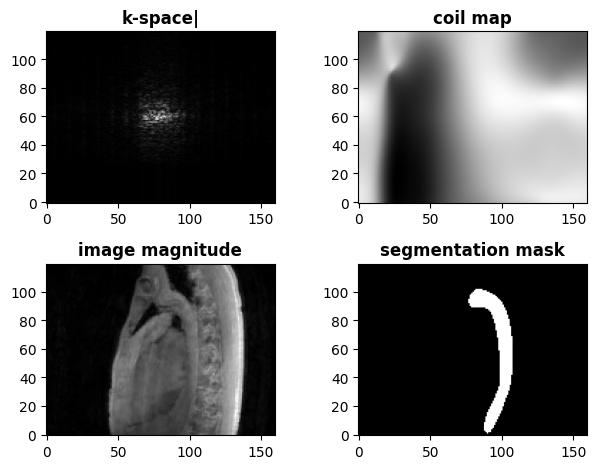

In [4]:
# Indices to visualize one slice/time/velocity/coil
showz = 14   # slice index (SPE / z)
showt = 1    # time frame index (Nt)
showv = 2    # velocity-encoding index (Nv)
showc = 0    # coil/channel index (Nc)


# (1) k-space magnitude for the selected (v, t, c, z)
plt.subplot(221)
plt.imshow(np.abs(kdata_full[showv, showt, showc, showz, :, :]).T,
           cmap='gray', origin='lower')
plt.title("k-space|", fontweight='bold')

# (2) coil sensitivity magnitude for the selected coil and slice
plt.subplot(222)
plt.imshow(np.abs(coilmap[showc, showz, :, :]).T,
           cmap='gray', origin='lower')
plt.title("coil map", fontweight='bold')

# (3) reconstructed image magnitude for the selected (v, t, z)
plt.subplot(223)
plt.imshow(np.abs(img[showv, showt, showz, :, :]).T,
           cmap='gray', origin='lower')
plt.title("image magnitude", fontweight='bold')

# (4) segmentation mask for the selected slice
plt.subplot(224)
plt.imshow(segmask[showz, :, :].T,
           cmap='gray', origin='lower')
plt.title("segmentation mask", fontweight='bold')

plt.tight_layout()
plt.show()

Assume each velocity-encoded complex image is
$$
\mathrm{img}_v(\mathbf{r}) = M_v(\mathbf{r})\,e^{i(\theta_0(\mathbf{r})+\theta_v(\mathbf{r}))},\quad v\in\{1,2,3\}.
$$

Using the reference encoding \(v=0\), the phase difference cancels the common phase:
$$
\theta_v(\mathbf{r})=\angle\!\left(\mathrm{img}_v(\mathbf{r})\,\overline{\mathrm{img}_0(\mathbf{r})}\right).
$$

Convert phase (radians) to velocity with VENC:
$$
\mathrm{vel}_v(\mathbf{r})=\frac{\theta_v(\mathbf{r})}{\pi}\,\mathrm{VENC}_v.
$$

In [5]:
# complex -> (magnitude, velocity)
mag, vel = complex2magflow(img, venc=np.array(params['VENC']))
print("velocity shape:", vel.shape)

velocity shape: (3, 12, 39, 160, 120)


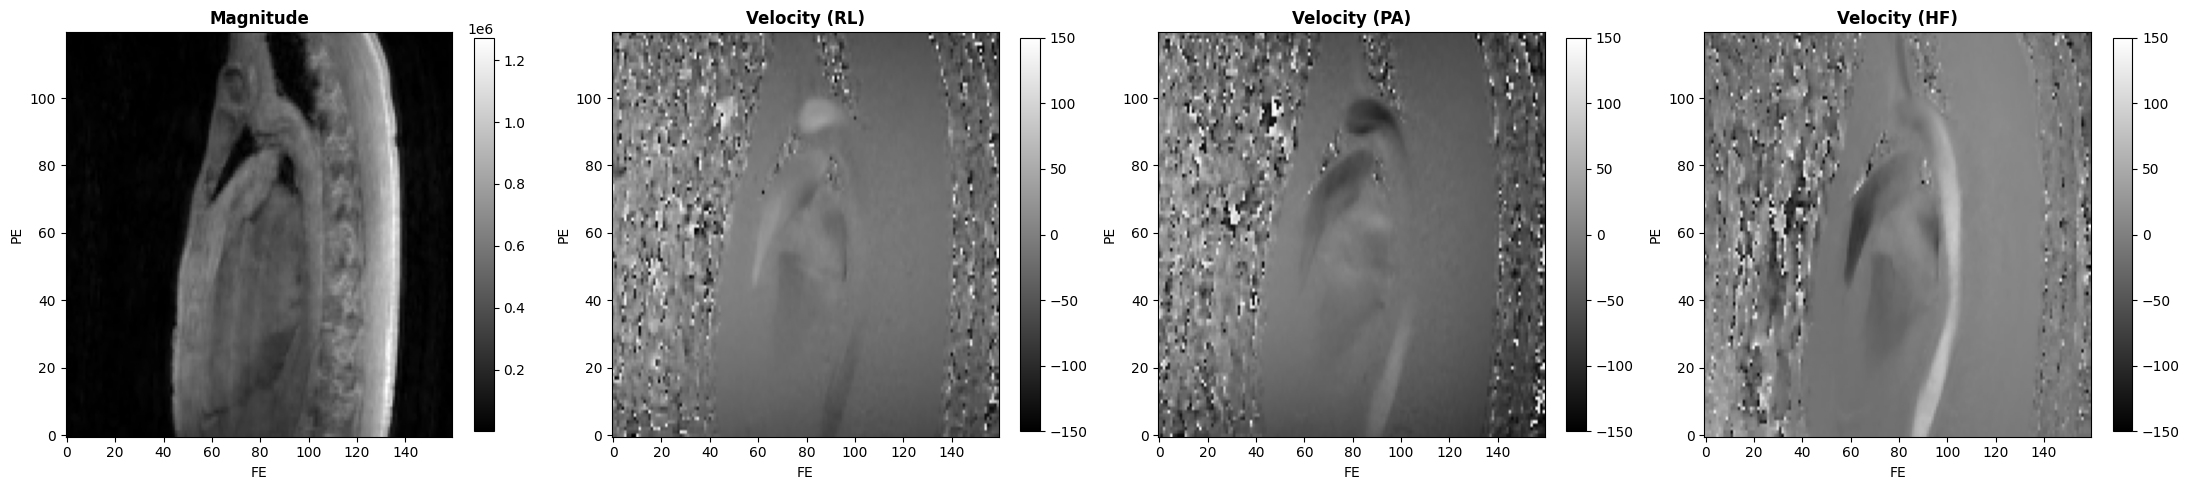

In [6]:
VENC   = np.array(params['VENC'])                 # [Vx, Vy, Vz] limits
VOrder = np.array(params['venc_order'])           # Direction for each encoding

fig, axes = plt.subplots(1, 4, figsize=(22, 5))

# (1) Magnitude
im0 = axes[0].imshow(np.abs(mag[showv, showt, showz, :, :]).T,
                     cmap='gray', origin='lower', aspect='auto')
axes[0].set_title("Magnitude", fontweight='bold')
axes[0].set_xlabel("FE"); axes[0].set_ylabel("PE")
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# (2~4) Velocity components (Vx, Vy, Vz)
for i in range(3):
    # If your flow has an extra Nv dim, change to: flow[showv, i, showt, showz, :, :]
    vi = vel[i, showt, showz, :, :]

    imi = axes[i+1].imshow(vi.T.astype(np.float32),
                           cmap='gray', origin='lower', aspect='auto',
                           vmin=-VENC[i], vmax=VENC[i])
    axes[i+1].set_title(f"Velocity ({VOrder[i]})", fontweight='bold')
    axes[i+1].set_xlabel("FE"); axes[i+1].set_ylabel("PE")
    plt.colorbar(imi, ax=axes[i+1], fraction=0.046)

plt.tight_layout()
plt.show()